In [178]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker
import os

In [3]:
from importlib import reload
import sys
sys.path.append('')

# My packages
import signal_to_noise as sn

In [4]:
from inspect import getmembers, isfunction

function_list = [o[1] for o in getmembers(sn) if isfunction(o[1])]

function_list

[<function signal_to_noise.anomalies(data, hist)>,
 <function signal_to_noise.apply_along_helper(arr, axis, func1d)>,
 <function signal_to_noise.climatology(hist: xarray.core.dataset.Dataset, start=1850, end=1901)>,
 <function signal_to_noise.grid_noise_detrend(y)>,
 <function signal_to_noise.grid_trend(x, use=0)>,
 <function signal_to_noise.loess_filter(data: <built-in function array>, step_size=10)>,
 <function signal_to_noise.space_mean(data: xarray.core.dataset.Dataset)>]

In [5]:
ROOT_DIR = '/g/data/w40/ab2313/best'

In [6]:
os.listdir(ROOT_DIR)

['Complete_TAVG_LatLong1.nc',
 'Land_and_Ocean_Alternate_LatLong1_time_processed.nc',
 'Land_and_Ocean_Alternate_LatLong1.nc',
 'Land_and_Ocean_LatLong1.nc',
 'Land_and_Ocean_Alternate_LatLong1.nc_time_processed',
 'Complete_TAVG_Daily_EqualArea.nc']

In [7]:
fname = 'Land_and_Ocean_Alternate_LatLong1_time_processed'

In [8]:
xr_kwargs  = dict(chunks = dict(latitude = 100, longitude = 100, time  = 10))

In [9]:
best = xr.open_dataset(f'{ROOT_DIR}/{fname}.nc', drop_variables = ['climatology', 'land_mask'], **xr_kwargs)

In [10]:
best = best.rename({'latitude':'lat','longitude':'lon'})

# Best Anomalies

In [11]:
reload(sn)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/init/signal_to_noise.py'>

In [12]:
sn.climatology

<function signal_to_noise.climatology(hist: xarray.core.dataset.Dataset, start=1850, end=1901)>

In [13]:
help(sn.climatology)

Help on function climatology in module signal_to_noise:

climatology(hist: xarray.core.dataset.Dataset, start=1850, end=1901)
    CLIMATOLOGY
    Getting just the years for climatology. This should be for each pixel, the mean temperature
    from 1850 to 1900.
    
    Parameters
    ----------
    hist: xarray dataset with dimension time
    start: float/int of the start year.
    end: float/ind of the end year
    
    Returns:
    climatologyL xarray dataset with the mean of the time dimension for just the years from 
    start to end. Still contains all other dimensions (e.g. lat and lon) if passed in.



In [14]:
best_climatology = sn.climatology(best)
best_climatology

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lon          (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat          (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    temperature  (lat, lon) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


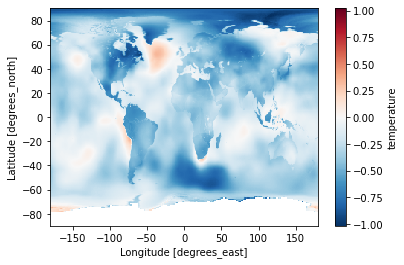

In [15]:
best_climatology.temperature.plot()

Anomalies from climatoloyg

In [16]:
best_anomaly = best - best_climatology

In [17]:
best_anomaly

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 2056)
Coordinates:
  * lon          (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat          (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time         (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2021-04-01
Data variables:
    temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>

# Getting the Space Mean

In [18]:
reload(sn)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/init/signal_to_noise.py'>

In [19]:
help(sn.space_mean)

Help on function space_mean in module signal_to_noise:

space_mean(data: xarray.core.dataset.Dataset)
    When calculating the space mean, the mean needs to be weighted by latitude.
    
    Parameters
    ----------
    data: xr.Dataset with both lat and lon dimension
    
    Returns
    -------
    xr.Dataset that has has the weighted space mean applied.



In [20]:
best_anomaly_smean = sn.space_mean(best_anomaly)

In [21]:
best_anomaly_smean = best_anomaly_smean.compute()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


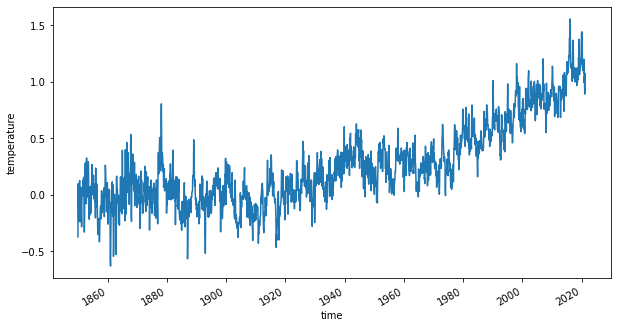

In [22]:
fig = plt.figure(figsize = (10,5))

best_anomaly_smean.temperature.plot()

# Signal to Noise

In [154]:
MONTHS_IN_YEAR = 12

In [155]:
ROLL_PERIOD = 30 * MONTHS_IN_YEAR
MIN_PERIODS = ROLL_PERIOD

In [156]:
ROLL_PERIOD, MIN_PERIODS

(360, 360)

## Signal

In [157]:
reload(sn)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/init/signal_to_noise.py'>

In [158]:
best_smean_signal = best_anomaly_smean.rolling(time = ROLL_PERIOD, min_periods = MIN_PERIODS, center = True)\
        .reduce(sn.apply_along_helper, func1d = sn.grid_trend) * ROLL_PERIOD

In [159]:
best_smean_signal

<xarray.Dataset>
Dimensions:      (time: 2056)
Coordinates:
  * time         (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2021-04-01
Data variables:
    temperature  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan

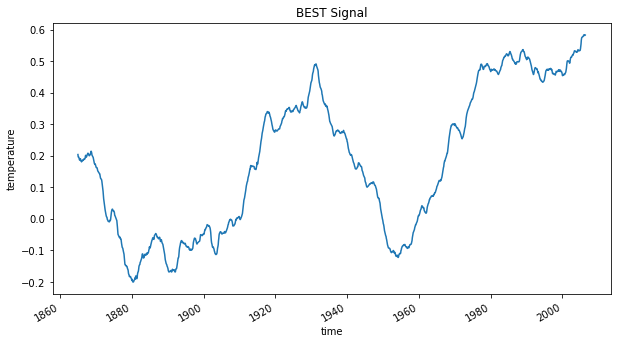

In [160]:
fig = plt.figure(figsize = (10,5))
best_smean_signal.temperature.plot()

plt.title('BEST Signal');

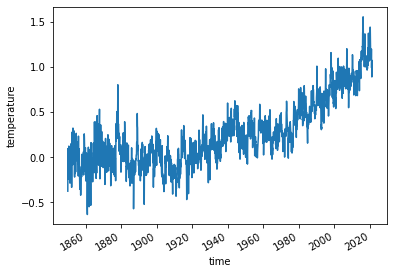

In [161]:
best_anomaly_smean.temperature.plot()

## Noise (Rolling)

Need to apply loess filter to data first

In [162]:
reload(sn)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/init/signal_to_noise.py'>

In [163]:
help(sn.loess_filter)

Help on function loess_filter in module signal_to_noise:

loess_filter(y: <built-in function array>, step_size=10)
    Applies the loess filter to a 1D numpy array.
    
    Parameters
    -----------
    data: the 1D array of values to apply the loess filter to
    step_size: the number of steps in each of the loess filter. The default is 50 points 
    in each window.
    
    Returns
    -------
    yhat: the data but, the loess version.
    
    Example
    -------
    >>> mean_temp = data.temp.values
    >>> mean_temp_loess = loess_filter(mean_temp)
    >>> 
    >>> # The mean temperature that has been detrended using the loess method.
    >>> mean_temp_loess_detrend = mean_temp - mean_temp_loess



In [224]:
best_smean_loess = sn.loess_filter(best_anomaly_smean.temperature, step_size = 41 * 12)

In [225]:
len(best_smean_loess)

2056

In [226]:
best_smean_loess_detrend = best_anomaly_smean - best_smean_loess

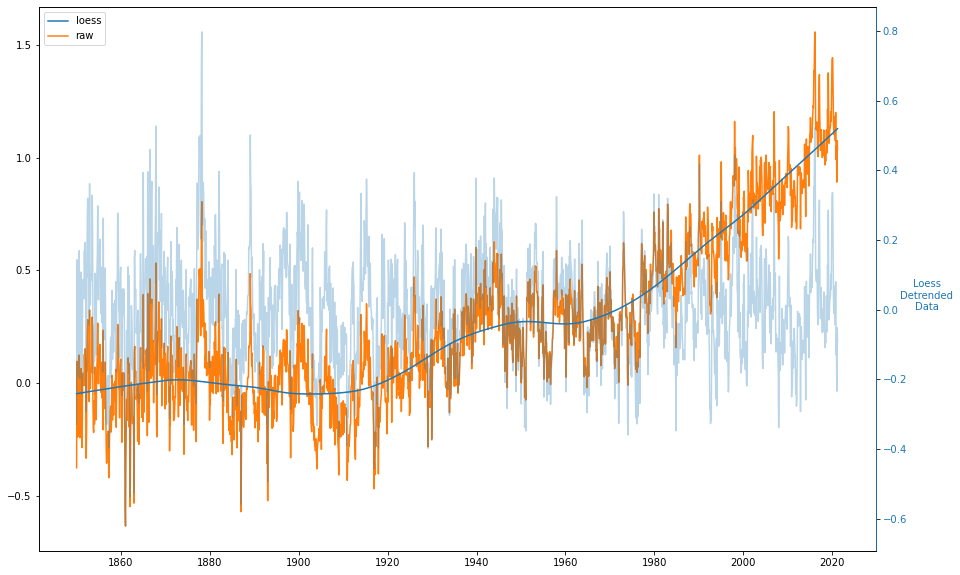

In [227]:
fig = plt.figure(figsize = (15,10))

ax = fig.add_subplot(111)
ax.plot(best_anomaly_smean.time.values, best_smean_loess, label = 'loess')
ax.plot(best_anomaly_smean.time.values, best_anomaly_smean.temperature.values, label = 'raw', zorder = -1)
ax.legend()


ax2 = ax.twinx()
ax2.plot(best_smean_loess_detrend.time.values,best_smean_loess_detrend.temperature.values, zorder = -3, alpha = 0.3)
c2 = plt.gca().lines[0].get_color()

ax2.tick_params(axis = 'y', labelcolor = c2)
ax2.spines['right'].set_color(c2)
ax2.set_ylabel('Loess\nDetrended\nData', rotation  = 0, labelpad = 20, c = c2);

In [228]:
best_smean_noise = \
    best_smean_loess_detrend.rolling(time = ROLL_PERIOD, min_periods = MIN_PERIODS, center = True).std()

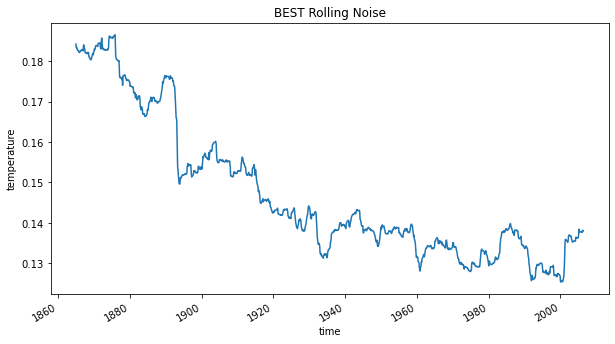

In [229]:
fig = plt.figure(figsize = (10,5))

best_smean_noise.temperature.plot()

plt.title('BEST Rolling Noise');

## Signal to Noise

In [230]:
best_smean_sn = best_smean_signal.temperature/ best_smean_noise.temperature
best_smean_sn.name = 'S/N'

In [231]:
ROLL_PERIOD

360

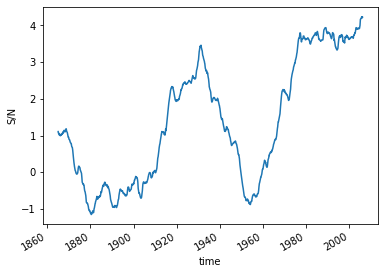

In [232]:
best_smean_sn.plot()

In [233]:
best_smean_sn['time'] = best_smean_sn['time'] - pd.to_timedelta(f'{int((ROLL_PERIOD/MONTHS_IN_YEAR)/2)}Y')

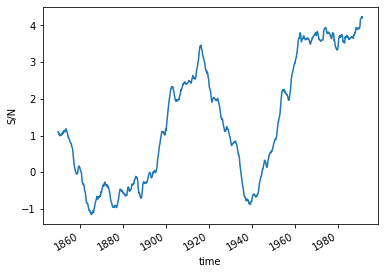

In [234]:
best_smean_sn.plot()

In [235]:
UNUSUAL = 2
UNKNOWN = 3

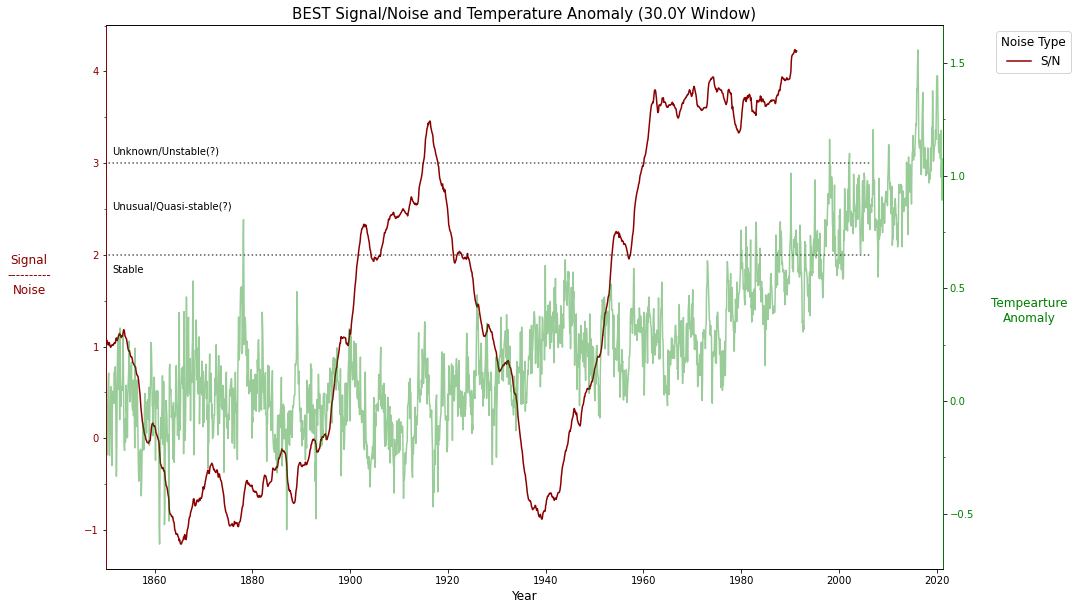

In [236]:
fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)

time =  best_smean_sn.time.values

ax.plot(time,best_smean_sn, label = 'S/N', c = 'darkred')

c0 = plt.gca().lines[0].get_color()
ax.tick_params(axis = 'y', labelcolor = c0)
ax.set_ylabel('Signal\n----------\nNoise', fontsize = 12, color = c0, rotation = 0, labelpad = 55);

leg = ax.legend(ncol = 1, fontsize = 12, bbox_to_anchor = [1.16, 1])
leg.set_title('Noise Type')
leg.get_title().set_fontsize('12')

ax.plot([time[0], time[-1]],[UNUSUAL, UNUSUAL], color = 'k', linestyle = ':', alpha = 0.65)
ax.plot([time[0], time[-1]],[UNKNOWN, UNKNOWN], color = 'k', linestyle = ':', alpha = 0.65)

ANNOTATE_X = 15
ax.annotate('Unusual/Quasi-stable(?)', xy = (best_anomaly_smean.time.values[ANNOTATE_X], UNUSUAL + 0.5), ha = 'left')
ax.annotate('Unknown/Unstable(?)', xy = (best_anomaly_smean.time.values[ANNOTATE_X], UNKNOWN + 0.1), ha = 'left')
ax.annotate('Stable', xy = (best_anomaly_smean.time.values[ANNOTATE_X], UNKNOWN - 1.2), ha = 'left')

ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(.5))

# Second y-axis: the temperature anomalies.
ax2 = ax.twinx()

ax2.plot(best_anomaly_smean.time.values, best_anomaly_smean.temperature.values, color = 'green', alpha = 0.4, label  = 'Temp Anomaly')

c1 = plt.gca().lines[0].get_color()
ax2.tick_params(axis = 'y', labelcolor = c1)
ax2.spines['right'].set_color(c1)
ax2.spines['left'].set_color(c0)
ax2.set_ylabel('Tempearture\nAnomaly', fontsize = 12, color = c1, rotation = 0, labelpad = 55);
ax2.yaxis.set_major_locator(mticker.MultipleLocator(.5))
ax2.yaxis.set_minor_locator(mticker.MultipleLocator(.25))

ax2.set_xlim([time[0], time[-1]])
ax.set_xlabel('Year', fontsize = 12);
ax.set_xlim(best_anomaly_smean.time.values[0], best_anomaly_smean.time.values[-1])
# ax.grid(which = 'major', axis = 'both', linestyle = ':', alpha = 0.5, zorder = -100)

ax.set_title(f'BEST Signal/Noise and Temperature Anomaly ({ROLL_PERIOD/MONTHS_IN_YEAR}Y Window)', size = 15);

# Class Extension Test

In [73]:
class xarrayExtension(xr.Dataset):
    __slots__ = ['data']
    
    def __init__(self, data):
        self._data = data

In [74]:
xarrayExtension(best_anomaly_smean)

AttributeError: cannot set attribute '_data' on a 'xarrayExtension' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.